In [50]:
!pip install xgboost

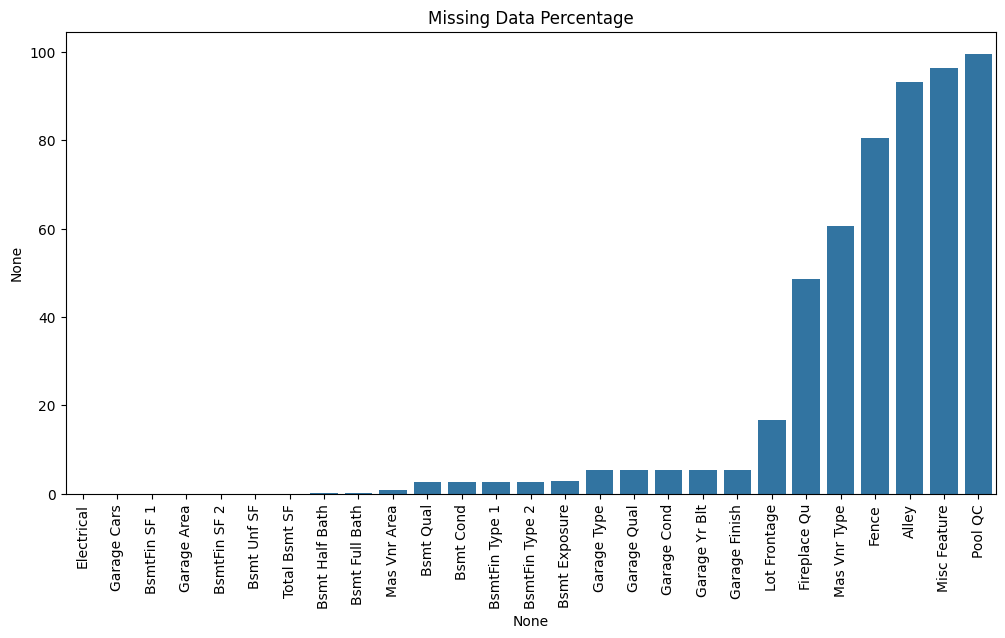

In [51]:
# 📚 Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# 🧾 Load dataset
dataset = pd.read_csv("AmesHousing.csv")

# 🧹 Drop PID
dataset = dataset.drop('PID', axis=1)

# 🔍 Check for missing data
def missing_percent(df):
    nan_percent = 100 * (df.isnull().sum() / len(df))
    nan_percent = nan_percent[nan_percent > 0].sort_values()
    return nan_percent

nan_percent = missing_percent(dataset)

# 📉 Visualize missing data
plt.figure(figsize=(12, 6))
sns.barplot(x=nan_percent.index, y=nan_percent)
plt.xticks(rotation=90)
plt.title("Missing Data Percentage")
plt.show()


In [52]:
# Remove outliers where 'Gr Liv Area' > 4000 and 'SalePrice' < 400000
index_drop = dataset[(dataset['Gr Liv Area'] > 4000) & (dataset['SalePrice'] < 400000)].index
dataset = dataset.drop(index_drop, axis=0)


In [53]:
# Drop rows with missing 'Electrical' or 'Garage Area'
dataset = dataset.dropna(subset=['Electrical', 'Garage Area'])

# Fill basement-related numerical columns with 0
bsmt_num_cols = ['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']
dataset[bsmt_num_cols] = dataset[bsmt_num_cols].fillna(0)

# Fill basement string columns with 'None'
bsmt_str_cols = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']
dataset[bsmt_str_cols] = dataset[bsmt_str_cols].fillna('None')

# Masonry veneer
dataset['Mas Vnr Type'] = dataset['Mas Vnr Type'].fillna('None')
dataset['Mas Vnr Area'] = dataset['Mas Vnr Area'].fillna(0)

# Garage columns
gar_str_cols = ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']
dataset[gar_str_cols] = dataset[gar_str_cols].fillna('None')
dataset['Garage Yr Blt'] = dataset['Garage Yr Blt'].fillna(0)

# Drop features with too much missing data
dataset = dataset.drop(['Fence', 'Alley', 'Misc Feature', 'Pool QC'], axis=1)

# Fill Lot Frontage by Neighborhood mean
dataset['Lot Frontage'] = dataset.groupby('Neighborhood')['Lot Frontage'].transform(lambda x: x.fillna(x.mean()))
dataset['Lot Frontage'] = dataset['Lot Frontage'].fillna(0)  # backup fill


In [54]:
# Convert MS SubClass to string (categorical)
dataset['MS SubClass'] = dataset['MS SubClass'].astype(str)

# Separate numerical and categorical
dataset_num = dataset.select_dtypes(exclude='object')
dataset_obj = dataset.select_dtypes(include='object')

# One-hot encode categorical features
dataset_obj = pd.get_dummies(dataset_obj, drop_first=True)

# Combine
finaldata = pd.concat([dataset_num, dataset_obj], axis=1)


In [55]:
# Split into features and target
X = finaldata.drop('SalePrice', axis=1)
y = finaldata['SalePrice']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [56]:
# Import modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd

# Define evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    
    print(f"Model: {model.__class__.__name__}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"MAE:  {mae:,.2f}")
    print(f"R^2:  {r2:.4f}")
    
    return rmse, mae, r2


In [57]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_rmse, rf_mae, rf_r2 = evaluate_model(rf_model, X_train, X_test, y_train, y_test)


Model: RandomForestRegressor
RMSE: 23,012.67
MAE:  14,625.29
R^2:  0.9254


In [58]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_rmse, gb_mae, gb_r2 = evaluate_model(gb_model, X_train, X_test, y_train, y_test)


Model: GradientBoostingRegressor
RMSE: 19,620.18
MAE:  12,985.46
R^2:  0.9458


In [59]:
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_rmse, xgb_mae, xgb_r2 = evaluate_model(xgb_model, X_train, X_test, y_train, y_test)


Model: XGBRegressor
RMSE: 20,433.55
MAE:  13,368.89
R^2:  0.9412


In [60]:

lasso_model = Lasso(alpha=0.1, max_iter=10000, random_state=42)
lasso_rmse, lasso_mae, lasso_r2 = evaluate_model(lasso_model, X_train, X_test, y_train, y_test)

Model: Lasso
RMSE: 21,467.90
MAE:  14,357.25
R^2:  0.9351


/Users/dat/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.342e+11, tolerance: 1.453e+09
  model = cd_fast.enet_coordinate_descent(


In [63]:
results = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting', 'XGBoost', 'Lasso'],
    'RMSE': [rf_rmse, gb_rmse, xgb_rmse, lasso_rmse],
    'R^2': [rf_r2, gb_r2, xgb_r2, lasso_r2],
    'MAE': [rf_mae, gb_mae, xgb_mae, lasso_mae]
})

results.sort_values(by='RMSE')


,Model,RMSE,R^2,MAE
1,Gradient Boosting,19620.182611,0.945806,12985.457328
2,XGBoost,20433.550450,0.941220,13368.886719
3,Lasso,21467.904402,0.935118,14357.253323
0,Random Forest,23012.671084,0.925445,14625.290444
